In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Functions to plot the data

In [181]:
def plotdata(filename='./sim_perf.txt', ttl=''):
    sd = pd.read_csv(filename, sep=';')
    sd['loss'] = sd['loss'].astype(float)
    sd['epsilon'] = sd['epsilon'].astype(float)
    sd['percentselect'] = sd['nselect'] / (sd['nselect'] + sd['nskip'])
    plt.figure(figsize=(16, 8))
    plt.title(ttl)
    plt.plot(sd['epoch'], sd['oracleF1'], c='red', label='Oracle F1')
    plt.plot(sd['epoch'], sd['randomF1'], c='pink', label='Random F1')
    plt.plot(sd['epoch'], sd['rougeF1'], c='blue', label='F1')
    plt.plot(sd['epoch'], sd['rougePrecision'], c='green', label='Precision')
    plt.plot(sd['epoch'], sd['rougeRecall'], c='purple', label='Recall')
    plt.plot(sd['epoch'], sd['percentselect'], c='orange', label='Select Rate')
    plt.ylim([0,1])
    plt.ylabel("Rouge, Loss, & Epsilon value")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.15))
    plt.grid()
    plt.show()
    plt.figure(figsize=(16, 4))
    plt.plot(sd['epoch'], sd['loss'], c='red', label='Loss')
    plt.legend()
    plt.grid()
    plt.show()
    return sd
    
def plotCompare(bowfile, lstmfile, ttl=''):
    bdf = pd.read_csv(bowfile, sep=';')
    ldf = pd.read_csv(lstmfile, sep=';')
    bdf['percentselect'] = bdf['nselect'] / (bdf['nselect'] + bdf['nskip'])
    ldf['percentselect'] = ldf['nselect'] / (ldf['nselect'] + ldf['nskip'])

    fig = plt.figure(figsize=(16, 4))
    plt.title(ttl)
    plt.plot(bdf['epoch'], bdf['oracleF1'], c='red', label='Oracle - F1')
    plt.plot(bdf['epoch'], bdf['rougeF1'], c='blue', label='BOW - F1')
    plt.plot(ldf['epoch'], ldf['rougeF1'], c='purple', label='LSTM - F1')
    plt.ylabel("Rouge F1")
    plt.xlabel("Training Epoch")
    plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.30))
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16, 4))
    plt.plot(bdf['epoch'], bdf['percentselect'], c='purple', label='BOW - Select Rate')
    plt.plot(ldf['epoch'], ldf['percentselect'], c='green', label='LSTM - Select Rate')
    plt.title("Selection Rate by Model")
    plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.30))
    plt.ylabel("Selection Rate")
    plt.xlabel("Training Epoch")
    plt.grid()
    plt.show()
    
def buildSelection(model, nepochs):
    ofile_names = [('./plotdata/%s/%i_epoch.txt' % (model, x) ) for x in range(nepochs) ] 
    for (ofile, epoch) in zip(ofile_names, range(nepochs)):
        odf = pd.read_csv(ofile, sep=';')
        if epoch==0:
            tdf = pd.DataFrame(pd.Series(odf['Skip']))
            tdf['Select'] = odf['Select']
        else:
            tdf['Skip'] += odf['Skip']
            tdf['Select'] += odf['Select']
            
    tdf['SkipRate'] = tdf['Skip'] / float(nepochs)
    tdf['SelectRate'] = tdf['Select'] / float(nepochs)
    tdf = tdf.reset_index()
    return tdf
    
def plotSelection(bowmodel, lstmmodel, nepochs):
    bowdf = buildSelection(bowmodel, nepochs)
    lstmdf = buildSelection(lstmmodel, nepochs)
    f, axarr = plt.subplots(1, 2, figsize=(16,8))
    axarr[0].barh(bowdf['index'], bowdf['SelectRate'], color='red', edgecolor='white')
    axarr[0].set_ylim(axarr[0].get_ylim()[::-1])
    axarr[1].barh(lstmdf['index'], lstmdf['SelectRate'], color='blue', edgecolor='white')
    axarr[1].set_ylim(axarr[1].get_ylim()[::-1])
    axarr[0].set_xlabel("Selection Percentage")
    axarr[1].set_xlabel("Selection Percentage")
    axarr[0].set_title('BOW')
    axarr[1].set_title('LSTM')
    f.suptitle("Sentence Selection Percentage across Epochs", fontsize=20, y=1.05)
    f.tight_layout()
    f.show()

---
# LSTM Model
---

## Learning Precision on 20 Records

In [167]:
! time th testModel.lua --nepochs 100 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 50

...Utils file loaded	
...running on CPU	
Running LSTM model to learn precision	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 1; Skipped  = 18}; Final Rouge Recall, Precision, F1 = {0.008222;0.640000;0.016235}	

real	7m1.967s
user	6m57.288s
sys	0m15.367s


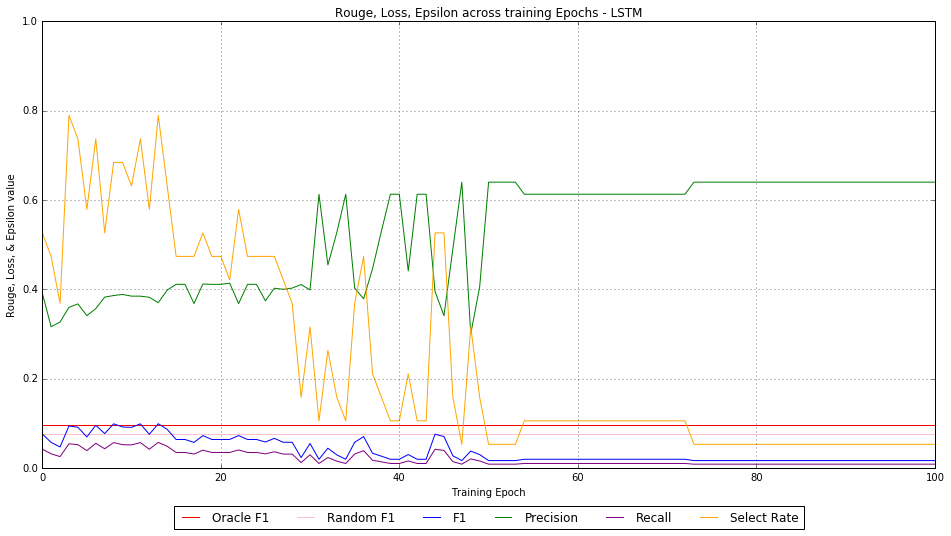

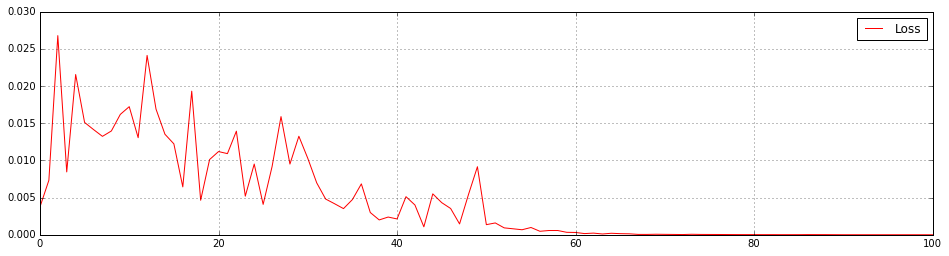

In [182]:
_ = plotdata('./lstm_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Example learning Recall on 20 Records

In [183]:
! time th testModel.lua --nepochs 100 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.05 --model lstm --end_baserate 50

...Utils file loaded	
...running on CPU	
Running LSTM model to learn recall	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 14; Skipped  = 5}; Final Rouge Recall, Precision, F1 = {0.053957;0.368421;0.094128}	

real	6m54.824s
user	6m51.359s
sys	0m14.162s


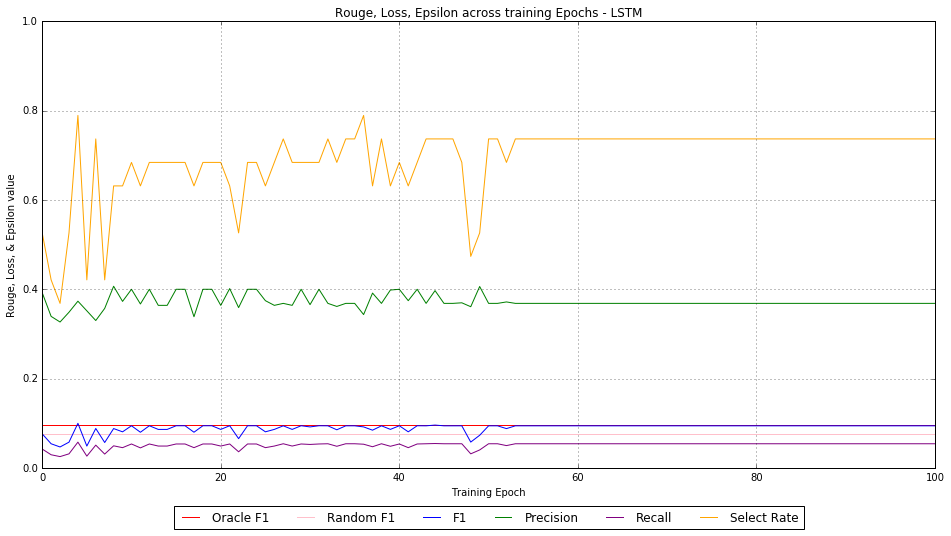

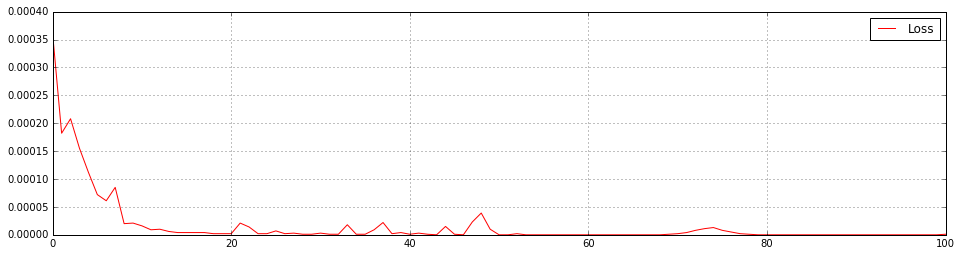

In [184]:
_ = plotdata('./lstm_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Example learning f1 on 20 Records

In [185]:
! time th testModel.lua --nepochs 500 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric f1 --n_samples 20 \
    --base_explore_rate 0.10 --model lstm --end_baserate 50

...Utils file loaded	
...running on CPU	
Running LSTM model to learn f1	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 15; Skipped  = 4}; Final Rouge Recall, Precision, F1 = {0.053957;0.350000;0.093500}	

real	33m13.545s
user	33m18.156s
sys	0m52.096s


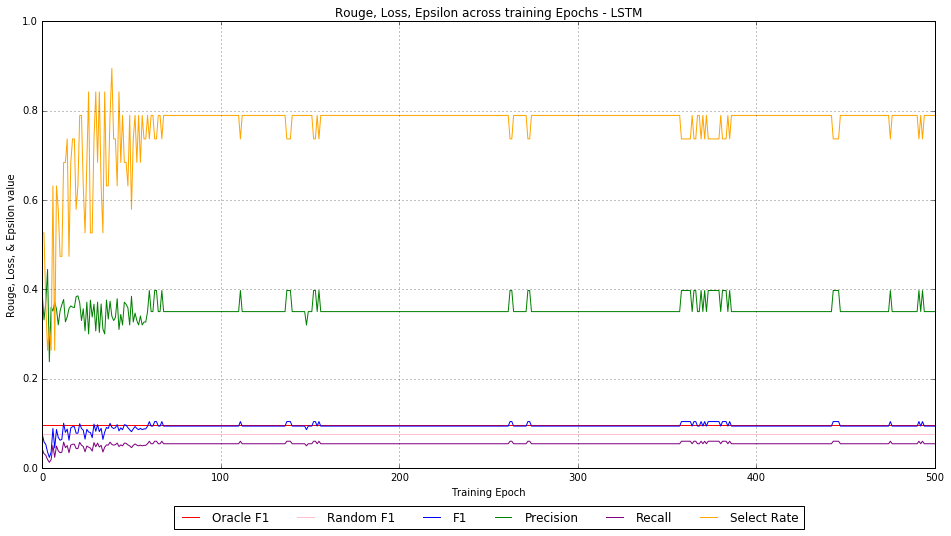

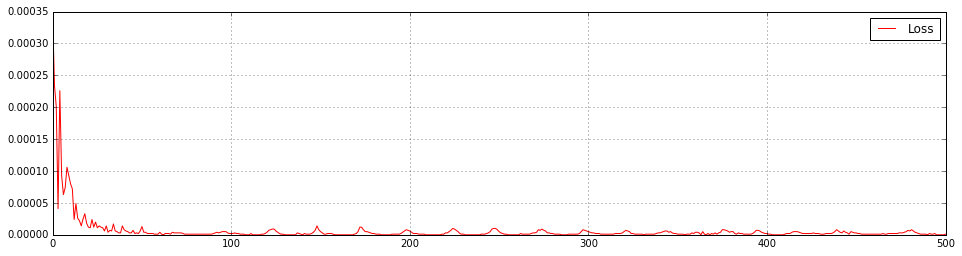

In [186]:
_ = plotdata('./lstm_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

---------
# BOW model
---------

## Example learning Precision on 20 Records

In [187]:
! time th testModel.lua --nepochs 100 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric precision --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 50

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn precision	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 7; Skipped  = 12}; Final Rouge Recall, Precision, F1 = {0.031860;0.433566;0.059359}	

real	0m24.914s
user	0m23.548s
sys	0m1.134s


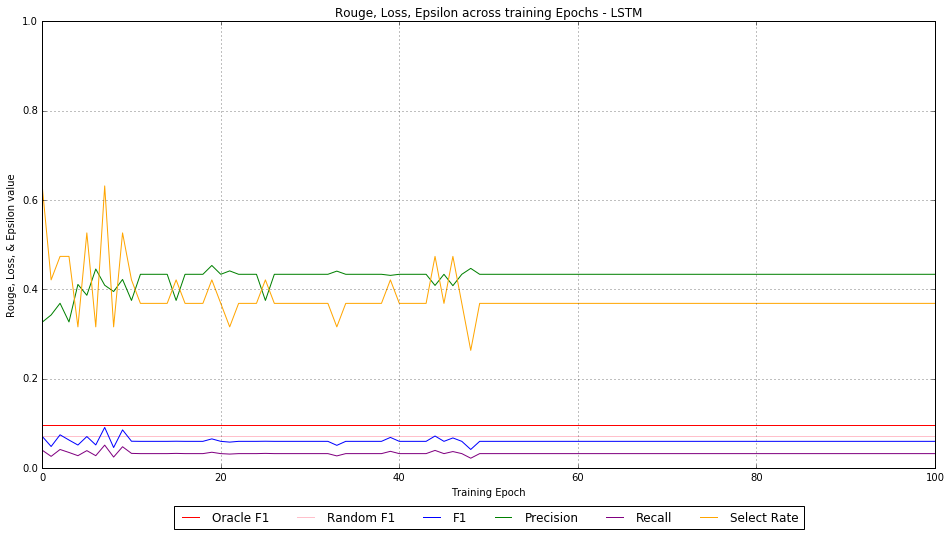

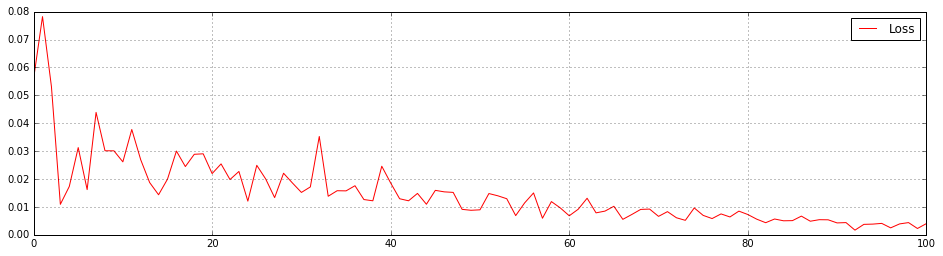

In [188]:
_ = plotdata('./bow_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning Recall on 20 Records

In [189]:
! time th testModel.lua --nepochs 100 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 50

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn recall	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 13; Skipped  = 6}; Final Rouge Recall, Precision, F1 = {0.051901;0.369963;0.091032}	

real	0m27.802s
user	0m26.012s
sys	0m1.216s


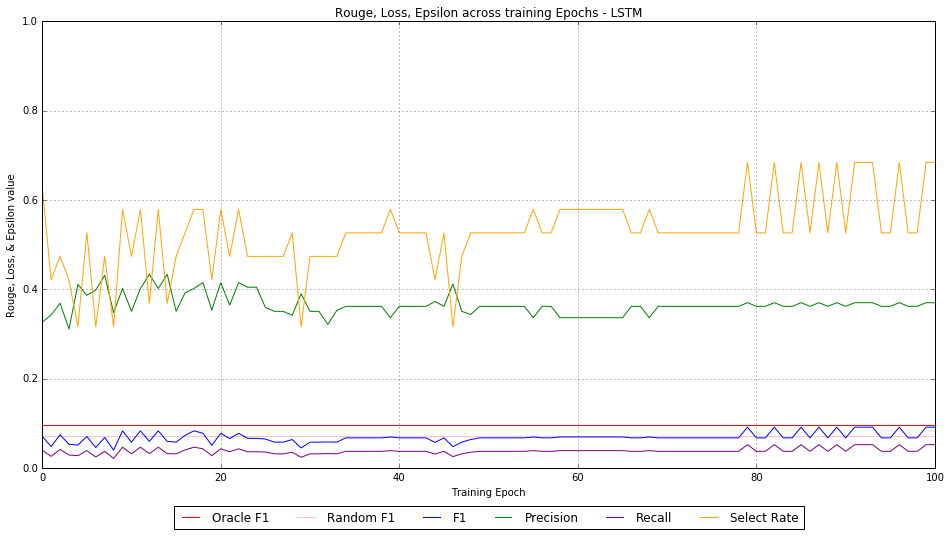

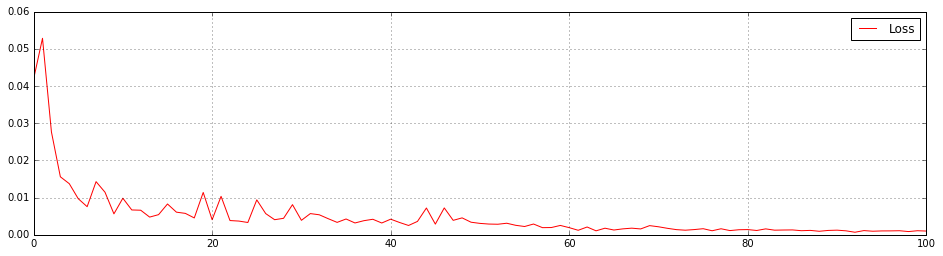

In [190]:
_ = plotdata('./bow_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

## Learning F1 on 20 Records

In [191]:
! time th testModel.lua --nepochs 500 --gamma 0. \
    --learning_rate 1e-4 --cuts 10 \
    --edim 50 --mem_size 300 --metric recall --n_samples 20 \
    --base_explore_rate 0.05 --model bow --end_baserate 50

...Utils file loaded	
...running on CPU	
Running bag-of-words model to learn recall	
Oracle - Greedy Search F1 = 0.095365 with 14 sentences selected	
Model complete {Selected = 6; Skipped  = 13}; Final Rouge Recall, Precision, F1 = {0.023638;0.389831;0.044574}	

real	2m0.846s
user	1m58.079s
sys	0m2.087s


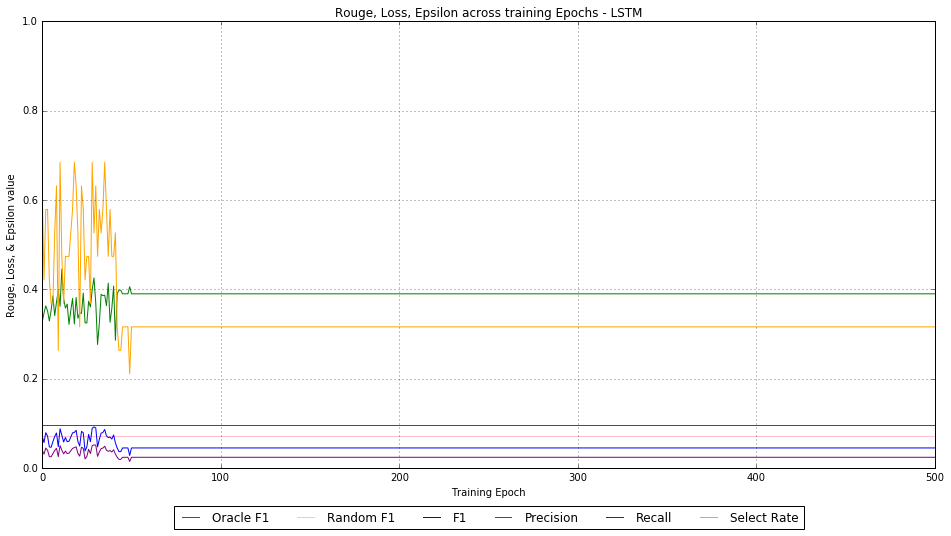

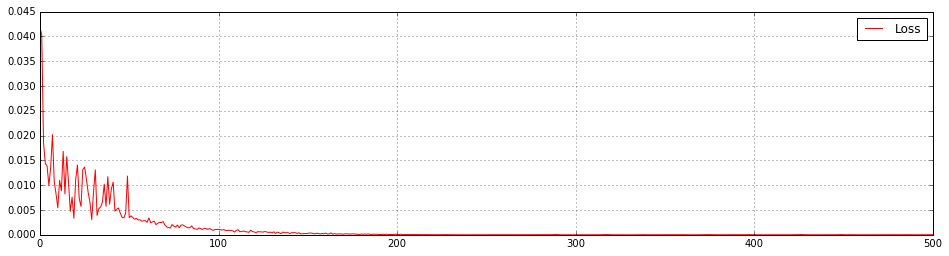

In [192]:
_ = plotdata('./bow_perf.txt', 'Rouge, Loss, Epsilon across training Epochs - LSTM')

# Comparison of the models

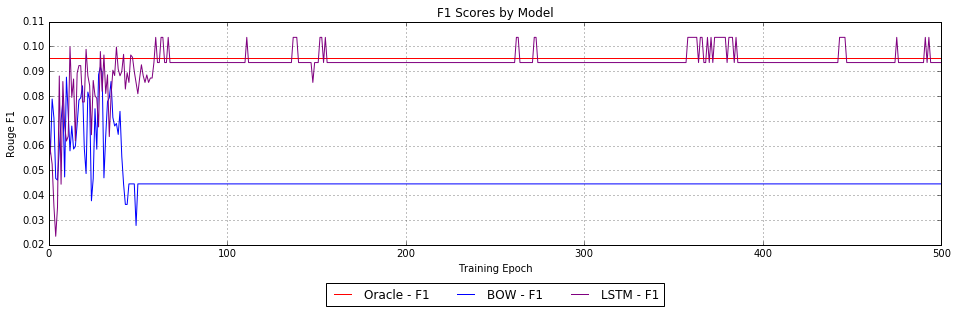

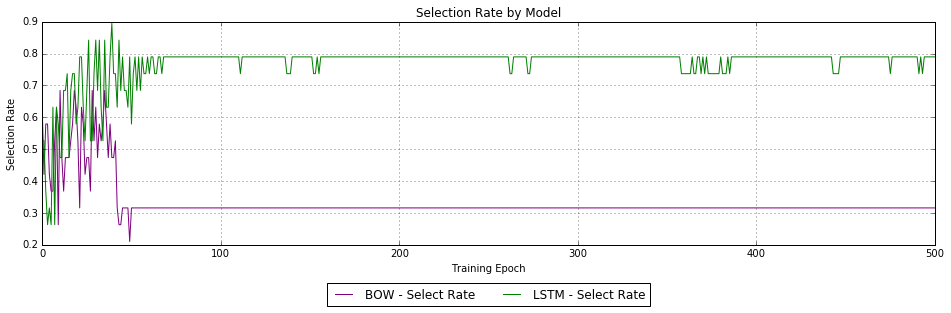

In [193]:
plotCompare('./bow_perf.txt', './lstm_perf.txt', 'F1 Scores by Model')

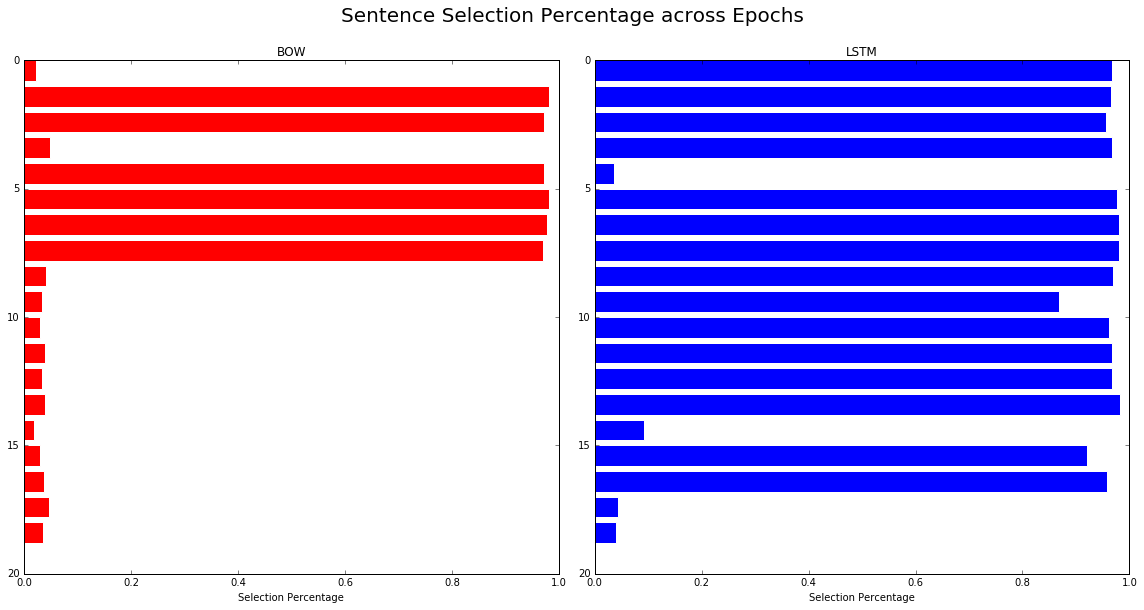

In [194]:
plotSelection('bow', 'lstm', 500)